In [2]:
#Handling the data
import pandas as pd 
import numpy as np

#For causal analysis
from dowhy import CausalModel
import matplotlib.pyplot as plt

#Sensitivity analysis
import sensemakr as smkr
import statsmodels.formula.api as smf
import scipy.stats as st

In [3]:
matches_df = pd.read_csv('./out/matches_df.csv')

We want to transform matches_df into a dataframe where each row represents one game for one team so that we can analyse the effect of goldlead at 15 has on team as an indiviual not as Team_A and team_B further interesting to plot the increase in win prob given that there is a gold lead 

Right now the large lead is defined as a one thousand goldlead at minute 15 but with one line of code one can replace that as seen later 

In [4]:
print(matches_df.dtypes)

Unnamed: 0.1             int64
Unnamed: 0               int64
gameid                  object
date                    object
league                  object
playoffs                 int64
patch                  float64
gamelength               int64
days_since_patch         int64
team_a                  object
team_b                  object
winner                  object
recent_patch             int64
elo_a                  float64
elo_b                  float64
winstreak_a            float64
winstreak_b            float64
elo_diff               float64
underdog                object
underdog_side_adv        int64
upset                    int64
vision_score_team_A    float64
vision_score_team_B    float64
team_kills_team_A      float64
team_kills_team_B      float64
abs_golddiff_15        float64
golddiffat15           float64
total_kills            float64
vision_diff            float64
large_lead_A             int64
large_lead_B             int64
resultA                  int64
resultB 

In [5]:
#We need to define columns that would be identical for each team 
common_cols = ['gameid', 'date', 'league', 'patch', 'playoffs', 'gamelength', 
               'days_since_patch', 'golddiffat15', 'recent_patch']

#Now for team-specific columns 
team_cols = {
    'blue': {
        'teamid': 'team_a',
        'result': 'resultA',
        'win_prob': 'win_prob_A',
        'large_lead': 'large_lead_A',
        'underdog': 'underdog_A',
        'elo': 'elo_a',
        'kills' : 'team_kills_team_A',
        'winstreak': 'winstreak_a',
        'visionscore': 'vision_score_team_A'
    },
    'red': {
        'teamid': 'team_b',
        'result': 'resultB',
        'win_prob': 'win_prob_B',
        'large_lead': 'large_lead_B',
        'underdog': 'underdog_B',
        'elo': 'elo_b',
        'kills' : 'team_kills_team_B',
        'winstreak': 'winstreak_b',
        'visionscore': 'vision_score_team_B'
    }
}

long_dfs = []
for side, mapping in team_cols.items():
    df = matches_df[common_cols + list(mapping.values())].copy()
    df = df.rename(columns={
        mapping['teamid']: 'teamid',
        mapping['result']: 'result',
        mapping['win_prob']: 'win_prob',
        mapping['large_lead']: 'large_lead',
        mapping['underdog']: 'underdog',
        mapping['elo']: 'elo',
        mapping['winstreak']: 'winstreak',
        mapping['kills']: 'kills',
        mapping['visionscore']: 'visionscore'
    })
    df['side'] = side  # 'A' or 'B'
    long_dfs.append(df)

long_df = pd.concat(long_dfs, ignore_index=True)

long_df['golddiffat15'] = long_df.apply(
    lambda row: row['golddiffat15'] if row['side'] == 'blue' else -row['golddiffat15'],
    axis=1
)
long_df['side_adv'] = long_df.apply(
    lambda row: 1 if row['side'] == 'blue' else 0, 
    axis=1
)
# Then redefine large_lead based on the updated golddiffat15
long_df['large_lead'] = (long_df['golddiffat15'] > 1000).astype(int)

In [6]:
print(long_df.dtypes)

gameid               object
date                 object
league               object
patch               float64
playoffs              int64
gamelength            int64
days_since_patch      int64
golddiffat15        float64
recent_patch          int64
teamid               object
result                int64
win_prob            float64
large_lead            int64
underdog               bool
elo                 float64
kills               float64
winstreak           float64
visionscore         float64
side                 object
side_adv              int64
dtype: object


In [7]:
def calculate_gold_lead_effect(causal_graph, gold_lead_threshold):
    #First we redefine the gold lead in the dataset
    long_df['large_lead'] = (long_df['golddiffat15'] > gold_lead_threshold).astype(int)

    #Then we run the estimation for said gold_lead_threshold with the given causal_graph
    #1. Build the model using the causal graph given
    model = CausalModel(
        data=long_df,
        treatment='large_lead',
        outcome='result',
        graph=causal_graph
    )

    #2. Use identification to identifiy the estimand
    identified_estimand = model.identify_effect()

    #3. Estimation (For now just using linear regression)
    estimate = model.estimate_effect(
        identified_estimand,
        method_name='backdoor.linear_regression'
    )

    #4. Refute the result
    refute_random_treatment = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
    )
    print(refute_random_treatment)

    #5. Return the value of the estimation 
    return estimate.value


In [ ]:
#To ignore future warnings
#Lets say we want to run over multiple gold leads to later model them 
gold_leads = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250,  2500, 2750,  3000, 3250,  3500, 3750, 4000, 4250, 4500]
effect_gold_lead = []

causal_graph = '''
digraph {
    large_lead -> result;
    win_prob -> large_lead;
    win_prob -> result;
    side_adv -> large_lead;
    side_adv -> result
}
'''

for threshold in gold_leads:
    retval = calculate_gold_lead_effect(causal_graph, threshold)
    effect_gold_lead.append(retval)

for i in range(len(effect_gold_lead)):
    print(f'Estimated effect of a {gold_leads[i]} large gold lead: {effect_gold_lead[i]}')

#Reset gold lead back to original
long_df['large_lead'] = (long_df['golddiffat15'] > 1000).astype(int)

AssertionError: invalid action: 'ingore'

In [ ]:
from sklearn.linear_model import LinearRegression

causal_graph = '''
digraph {
    golddiffat15 -> result;
    win_prob -> golddiffat15;
    win_prob -> result;
    side_adv -> golddiffat15;
    side_adv -> result
}
'''

# Build causal model directly on matches_df
model = CausalModel(
    data=long_df,
    treatment='golddiffat15',
    outcome='result',
    graph=causal_graph
)

# Identify effect
identified_estimand = model.identify_effect()

# Estimate causal effect using linear regression (backdoor)
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression'
)

refute_random_treatment = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
    )

continuous_estimate = estimate
unit_causal_effect = estimate.value


print("Causal Estimate causal effect of one unit in the golddiffat15 on the result:", estimate.value)
print(f"For example this would be the estimated effect when we have a golddiffat15 of 1000: {estimate.value * 1000}")

/opt/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

Causal Estimate causal effect of one unit in the golddiffat15 on the result: 0.0001340584142001111
For example this would be the estimated effect when we have a golddiffat15 of 1000: 0.1340584142001111


/opt/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Now we want to plot the causal effect as measured by one unit in the golddiffat15 and also as measured by the an amount of large_leads 

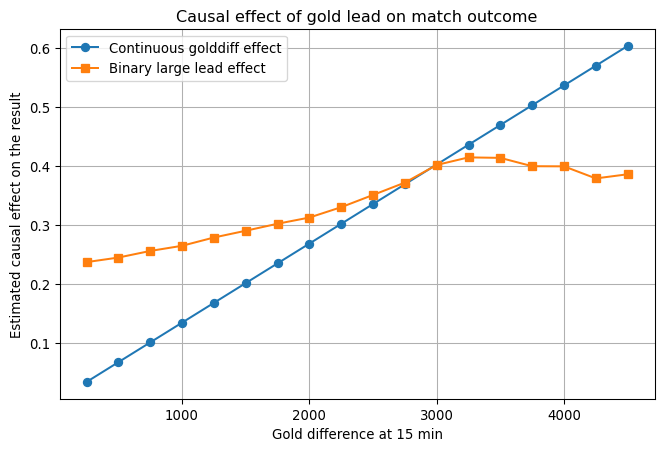

In [ ]:
#Get the effects measured by the unit effect from golddiffat15
continuous_effects = [unit_causal_effect * g for g in gold_leads]

plt.figure(figsize=(8,5))
plt.plot(gold_leads, continuous_effects, marker='o', label='Continuous golddiff effect')
plt.plot(gold_leads, effect_gold_lead, marker='s', label='Binary large lead effect')

plt.xlabel('Gold difference at 15 min')
plt.ylabel('Estimated causal effect on the result')
plt.title('Causal effect of gold lead on match outcome')
plt.legend()
plt.grid(True)
plt.savefig('./graphs/causal_effec_golddiffat15.pdf', format='pdf')
plt.show()

In [ ]:
#Save the long_df 
long_df.to_csv('./out/long_df.csv')

For visualization we want to now show the increase in win probability given the golddiffat15
We wills predict the win_prob given that goldlead by dividing the amount of games won with that gold lead by the amount of games with that gold lead

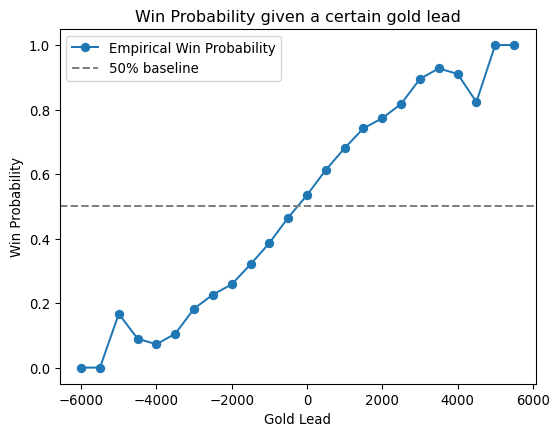

Win percentage increase from even gold to +1000 gold lead: 14.57%


In [ ]:
bin_size = 500
long_df['gold_bin'] = (long_df['golddiffat15'] // bin_size) * bin_size

empirical_win_prob = long_df.groupby('gold_bin')['result'].mean().reset_index()

plt.plot(empirical_win_prob['gold_bin'], empirical_win_prob['result'], marker='o', label='Empirical Win Probability')
plt.xlabel('Gold Lead')
plt.ylabel('Win Probability')
plt.title('Win Probability given a certain gold lead')
plt.axhline(0.5, color='gray', linestyle='--', label='50% baseline')
plt.legend()
plt.savefig('./graphs/winprob_given_goldlead.pdf', format='pdf')
plt.show()

baseline = long_df.loc[long_df['gold_bin'] == 0, 'result'].mean()
lead_1000 = long_df.loc[long_df['gold_bin'] == 1000, 'result'].mean()

increase = lead_1000 - baseline
print(f"Win percentage increase from even gold to +1000 gold lead: {increase*100:.2f}%")

The 13.52% increase is very close to the number we got by calculating the causal effect for the continouos variable golddiffat15 which was roughly 13.4%

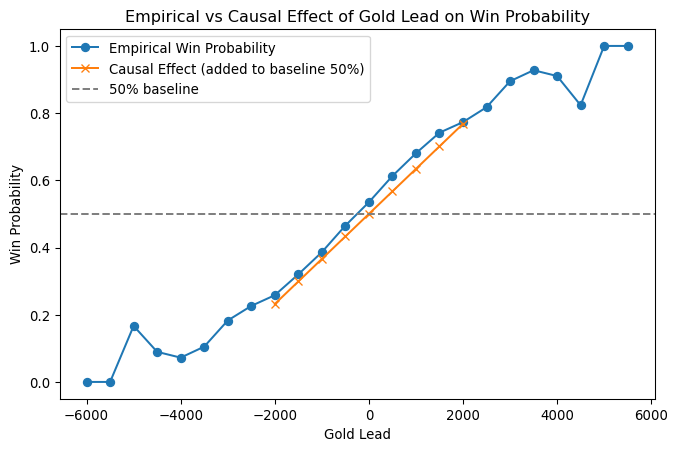

In [ ]:
#Now we plot the empirical win prob given a certain gold lead vs the unit causal effect of the gold lead on the result
gold_range = np.arange(-2000, 2001, 500)
causal_effect = unit_causal_effect * gold_range

plt.figure(figsize=(8,5))
plt.plot(empirical_win_prob['gold_bin'], empirical_win_prob['result'], marker='o', label='Empirical Win Probability')
plt.plot(gold_range, 0.5 + causal_effect, marker='x', label='Causal Effect (added to baseline 50%)')
plt.xlabel('Gold Lead')
plt.ylabel('Win Probability')
plt.title('Empirical vs Causal Effect of Gold Lead on Win Probability')
plt.axhline(0.5, color='gray', linestyle='--', label='50% baseline')
plt.legend()
plt.show()

In [ ]:
#We want to calculate a confidence interval using the standart erro 
se = continuous_estimate.get_standard_error()

#Calculate the 95percentile confidence interval
ci_lower, ci_upper = st.norm.interval(0.95, loc=unit_causal_effect, scale=se)
print(f"We estimate our confindence interval as [{ci_lower}, {ci_upper}]")
print(f"Our estimated causal effect is: {unit_causal_effect}")

We estimate our confindence interval as [[0.00013168], [0.00013644]]
Our estimated causal effect is: 0.0001340584142001111


In [ ]:
#We now fit a regression model using statsmodels to the data using the information gained 
#by the causal analysis to then use sensemakr to do sensitivity analysis
formula = 'result ~ golddiffat15 + side_adv + win_prob'
reg_model = smf.ols(formula, data=long_df).fit()

In [ ]:
print(long_df.dtypes)

gameid               object
date                 object
league               object
patch               float64
playoffs              int64
gamelength            int64
days_since_patch      int64
golddiffat15        float64
recent_patch          int64
teamid               object
result                int64
win_prob            float64
large_lead            int64
underdog               bool
elo                 float64
kills               float64
winstreak           float64
visionscore         float64
side                 object
side_adv              int64
gold_bin            float64
dtype: object


/opt/anaconda3/lib/python3.12/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/opt/anaconda3/lib/python3.12/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/opt/anaconda3/lib/python3.12/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

Sensitivity Analysis to Unobserved Confounding

Model Formula: result ~ golddiffat15 + side_adv + win_prob

Null hypothesis: q = 1 and reduce = True 

Unadjusted Estimates of ' golddiffat15 ':
  Coef. estimate: 0.0
  Standard Error: 0.0
  t-value: 110.242 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.084
  Robustness Value, q = 1 : 0.261
  Robustness Value, q = 1 alpha = 0.05 : 0.257 



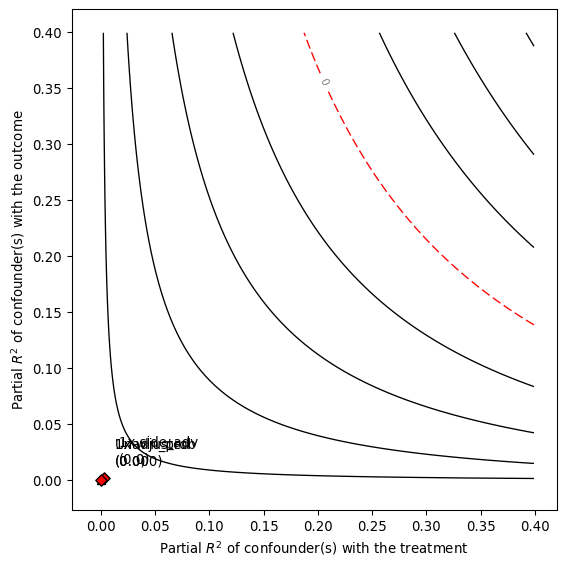

In [ ]:
#Use sensemakr to do sensitivity analysis
golddiff_sense = smkr.Sensemakr(
    model=reg_model,
    treatment='golddiffat15',
    benchmark_covariates=['side_adv', 'win_prob'],
)

#Plot the sensemakr results
golddiff_sense.plot()
golddiff_sense.print()

Our coefficient is 0.0 since it is rounded down the true value should be the same as the causal effect estimated

An unobserved confounder would need to be 26.1% strong to completely cancel out the result we got of the causal effect or to set it to 0 e.g. to explain it away

In [ ]:
html_code = golddiff_sense.ovb_minimal_reporting(format = "html")

Outcome: result 
 
 
 Treatment 
 Est. 
 S.E. 
 t-value 
 R 2 Y~D|X 
 RV q = 1 
 RV q = 1, α = 0.05 
 
 
 
 
 golddiffat15 
 0.0 
 0.0 
 110.2 
 8.4% 
 26.1% 
 25.7% 
 
 
 
 Note: df = 132136; Bound ( 1x side_adv ): R 2 Y~Z|X,D = 0.2%, R 2 D~Z|X =0.3%

Sensitivity analysis is based on the paper: Making Sense of Sensitivity: Extending Omitted Variable Bias Cinelli & Hazlett (2020)

In [ ]:
    #Introduce a threshold to underdog 
    long_df['underdog'] = (long_df['win_prob'] < 0.3).astype(int)
    print(f"Underdog for threshold 0.3: {long_df['underdog'].value_counts()}")

    long_df['underdog'] = (long_df['win_prob'] < 0.35).astype(int)
    print(f"Underdog for threshold 0.35: {long_df['underdog'].value_counts()}")

    long_df['underdog'] = (long_df['win_prob'] < 0.4).astype(int)
    print(f"Underdog for threshold 0.4: {long_df['underdog'].value_counts()}")

#Keep the 0.4 underdog for now as the threshold 

Underdog for threshold 0.3: underdog
0    131369
1       771
Name: count, dtype: int64
Underdog for threshold 0.35: underdog
0    128061
1      4079
Name: count, dtype: int64
Underdog for threshold 0.4: underdog
0    117929
1     14211
Name: count, dtype: int64
